In [2]:
### import and initialize modules ###
%load_ext autoreload
%autoreload 2

%matplotlib inline
# ! if you want to use this, run  'conda install -c conda-forge scalene' for your conda env
#%load_ext scalene 
# ! Or 'conda install -c conda-forge line_profiler' for this one.
%load_ext line_profiler
import sys
sys.path.append("../code")
import numpy as np
import pandas as pd # You might have to install this into your environment
import scipy.stats as stats 
from registration_project import rigid_reg_cc_demo, affine_reg_cc_demo, affine_reg_mi_demo

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [12]:
### import and read data ###
path = 'source\data\image_data'



In [13]:
### Registration ###
# We can proba
%lprun -f affine_reg_cc_demo affine_reg_cc_demo(r"../data/image_data/1_1_t1.tif",r"../data/image_data/1_1_t1_d.tif",False) # example, but not applicable for current usage
res = %timeit -o rigid_reg_cc_demo('../data/image_data/1_1_t1.tif','../data/image_data/1_1_t1_d.tif',False) # for the main registration problem

Final similarity of ca. 0.9299874408059998


Timer unit: 1e-07 s

Total time: 22.907 s
File: c:\Users\quint\Downloads\assignments\project-imgreg-group19\source\reader\../code\registration_project.py
Function: affine_reg_cc_demo at line 104

Line #      Hits         Time  Per Hit   % Time  Line Contents
   104                                           def affine_reg_cc_demo(img1,img2,imshow=False,num_iter=200, learning_rate=0.001):
   105                                           
   106                                               # read the fixed and moving images
   107                                               # change these in order to read different images
   108         1      26251.0  26251.0      0.0      I = plt.imread(img1)
   109         1      28586.0  28586.0      0.0      Im = plt.imread(img2)
   110                                           
   111                                               # initial values for the parameters
   112                                               # we start with the identity 

In [39]:
# Test variables to test statistical analysis(assume dataset of 10)
time_rigid = [64098,23249,0,0,57892,0,43897,0,0,0]
time_affine = [0,0,98022,78923,0,298200,0,89023,67239,29870]
time_rigid_all = [64098,23249,24798,58302,57892,42309,43897,28342,8902,78230]
time_affine_all = [78934,57832,98022,78923,78923,298200,83450,89023,67239,29870]

transformations = [[35,2.5,1.1,0.5,1,3,2],[12,1,2,1.6,1.1,0.3,4],[4,1.9,2.1,4,8,0,7],[2,1.2,1.4,2,3,1.5,1],[60,2.3,1.9,1.3,0.4,2,0],[34,1.4,2.2,6,3,0.4,0],[5,1,4.2,1.8,1.2,0.5,1.1],[0,2,1.2,0.3,0.1,1,1.7],[1,1,2.1,0.8,0.2,2,4],[9,1,1.2,0.8,0.2,2,2]]

Variance of comp. time for all rigid transformations:  424242879.89
Variance of comp. time for all affine transformations:  4862675666.639999
Variance of comp. time for the chosen transformations:  5570605978.410001
t test affine_all>rigid_all:  Ttest_indResult(statistic=2.1883712672394346, pvalue=0.02103570283721172)
t test affine_all>aggr:  Ttest_indResult(statistic=0.3230839013374063, pvalue=0.375177385807674)


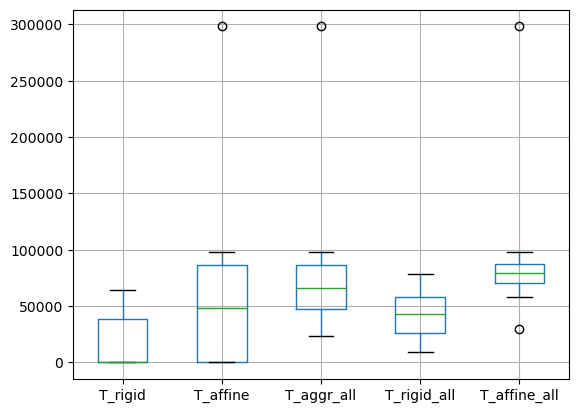

In [28]:
### Statistical analysis ###
# input: list of computation times per formula: rigid_cc_time, affine_cc_time, affine_mi_time --> no processing is done with this, these are nice-to-haves

# input: list of computation times per type of registration: time_rigid, time_affine, time_rigid_all, time_affine_all
# input: list of affine transformation matrices per registration: transformations (rot, scalex, scaley, shearx, sheary, translatex, translatey)

# output: significance testing between the types of registration
# output: power analysis of significance testing
# output: Boxplots for the computation time data spread


aggr_rigid_affine = [time_rigid[i]+time_affine[i] for i in range(len(time_rigid))] # List containing all tests, containing the time using our chosen method
data = np.hstack((time_rigid, time_affine, aggr_rigid_affine, time_rigid_all, time_affine_all))
df_time = pd.DataFrame({'T_rigid': time_rigid,
                        'T_affine': time_affine,
                        'T_aggr_all': aggr_rigid_affine,
                        'T_rigid_all': time_rigid_all,
                        'T_affine_all': time_affine_all})
box = df_time.boxplot(grid=True)
box.plot(figsize=(1,3), title="Boxplot of computation time of rigid and affine transformation registration")

# Test for equal variance
print("Variance of comp. time for all rigid transformations: ",np.var(a=df_time['T_rigid_all']))
print("Variance of comp. time for all affine transformations: ",np.var(a=df_time['T_affine_all']))
print("Variance of comp. time for the chosen transformations: ",np.var(a=df_time['T_aggr_all']))
     

# Variance vary less than factor 4:
    # Test if the computation time to use affine transformation compared to rigid transformation is longer
print("t test affine_all>rigid_all: ",stats.ttest_ind(a=df_time['T_affine_all'],b=df_time['T_rigid_all'], equal_var=True,alternative='greater')) 

    # Test if the aggregated computation time is shorter than all affine registration  
print("t test affine_all>aggr: ",stats.ttest_ind(a=df_time['T_affine_all'],b=df_time['T_aggr_all'], equal_var=True,alternative='greater'))

Mean of all scaling:  1.735
Mean of scaling of rigid:  1.9999999999999998
Mean of scaling of affine:  1.5583333333333333
Variance of all scaling:  0.5652749999999999
Variance of scaling of rigid:  0.9999999999999998
Variance of scaling of affine:  0.19743055555555558
Mean of all shear:  1.8649999999999998
Mean of shear of rigid:  1.1125
Mean of shear of affine:  2.3666666666666667
Variance of all shear:  4.072275
Variance of shear of rigid:  0.20609375000000002
Variance of shear of affine:  6.020555555555554


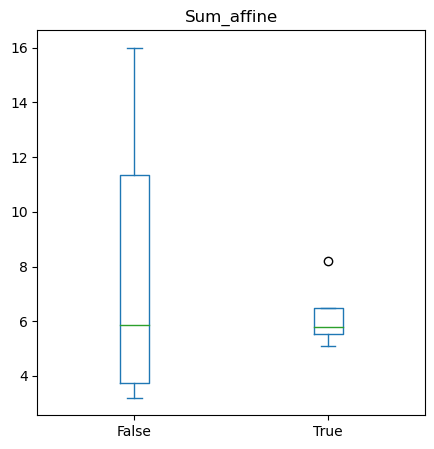

In [82]:
# See if our decision program is working well
rigid_decision = np.array([True if time_rigid[i]>0 else False for i in range(len(time_rigid))]) # Records if rigid was chosen

data2 = [rigid_decision]
sum_affine = [transformations[i][1]+transformations[i][2]+transformations[i][3]+transformations[i][4] for i in range(len(transformations))]
df_transform = pd.DataFrame({"Decision": rigid_decision,
                             "Sum_affine": sum_affine})
box2 = df_transform.plot.box(column="Sum_affine",by="Decision",figsize=(5,5)) # Boxplot that sums the affine parameters and groups them by our decision

# Basic statistics of the average shear and scaling present 
    # Scaling
print("Mean of all scaling: ",np.mean(np.array(transformations).reshape(10,6)[:,1:3]))
print("Mean of scaling of rigid: ", np.mean(np.array(transformations).reshape(10,6)[rigid_decision,1:3]))
print("Mean of scaling of affine: ", np.mean(np.array(transformations).reshape(10,6)[~rigid_decision,1:3]))

print("Variance of all scaling: ",np.var(np.array(transformations).reshape(10,6)[:,1:3]))
print("Variance of scaling of rigid: ", np.var(np.array(transformations).reshape(10,6)[rigid_decision,1:3]))
print("Variance of scaling of affine: ", np.var(np.array(transformations).reshape(10,6)[~rigid_decision,1:3]))

    #Shear
print("Mean of all shear: ",np.mean(np.array(transformations).reshape(10,6)[:,3:5]))
print("Mean of shear of rigid: ", np.mean(np.array(transformations).reshape(10,6)[rigid_decision,3:5]))
print("Mean of shear of affine: ", np.mean(np.array(transformations).reshape(10,6)[~rigid_decision,3:5]))

print("Variance of all shear: ",np.var(np.array(transformations).reshape(10,6)[:,3:5]))
print("Variance of shear of rigid: ", np.var(np.array(transformations).reshape(10,6)[rigid_decision,3:5]))
print("Variance of shear of affine: ", np.var(np.array(transformations).reshape(10,6)[~rigid_decision,3:5]))